# 1: Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import annotations
from sympy import symbols, Eq, solve, sin, cos, pi, cot, sqrt

# 2: Defining Necessary Objects and Associated Functions

## 2.1 Defining Point Object

In [ ]:
class Point:
  '''
  Creates a point on the surface.
    - float x: x coordinate
    - float y: y coordinate
    - list[Point] adj: list of adjacent points
    - tuple(float, float) imbal: direction of imbalance of the point
    - bool is_boundary: whether the point is a boundary point
  '''

  def __init__(self, x: float, y:float, is_boundary: bool = False):
    '''
    Constructor for Point
    '''
    self.x = x
    self.y = y
    self.adj = []
    self.adj_dirs = {}
    self.imbal = (0, 0)
    self.is_boundary = is_boundary

  def __str__(self) -> str:
    '''
    Returns a string representation of the point.
    '''
    return f'({self.x}, {self.y})'

  def add_pt(self, pt: Point) -> bool:
    '''
    Adds a point to the adjacent list and updates the adj_dirs dict. Returns
    True if successful, False otherwise.
    '''
    dist = np.sqrt((pt.x - self.x)**2 + (pt.y - self.y)**2)
    if (dist == 0):
      return False

    self.adj.append(pt)
    dir_x = (pt.x - self.x) / dist
    dir_y = (pt.y - self.y) / dist
    self.adj_dirs[pt] = (dir_x, dir_y)
    self._update_imbal()
    return True

  def remove_pt(self, pt: Point) -> bool:
    '''
    Removes a point from the adjacent list and updates the adj_dirs dict.
    Returns True if successful, False otherwise.
    '''
    if pt not in self.adj:
      return False
    self.adj.remove(pt)
    del self.adj_dirs[pt]
    self._update_imbal()
    return True

  def _update_adj_dirs(self) -> None:
    '''
    Updates the adj_dirs dict. Used as helper function for update_position
    '''
    for pt in self.adj:
      dist = np.sqrt((pt.x - self.x)**2 + (pt.y - self.y)**2)
      dir_x = (pt.x - self.x) / dist
      dir_y = (pt.y - self.y) / dist
      self.adj_dirs[pt] = (dir_x, dir_y)


  def _update_imbal(self) -> None:
    '''
    Updates the imbalance of the point using adj_dirs dict. Used as helper
    function for add_pt and remove_pt
    '''
    dir_x = 0
    dir_y = 0
    for dir in self.adj_dirs:
      dir_x += self.adj_dirs[dir][0]
      dir_y += self.adj_dirs[dir][1]
    self.imbal = (dir_x, dir_y)


  def update_position(self, x: float, y: float) -> None:
    '''
    Updates the position of the point.
    '''
    self.x = x
    self.y = y
    self._update_adj_dirs()
    self._update_imbal()

## 2.2: Defining Functions

### 2.2.1: Functions for Computing, Generating, and Processing Points

In [ ]:
def connect(p1: Point, p2: Point) -> bool:
  '''
  Connects two points together. Returns True if successful, False otherwise.
  '''
  return p1.add_pt(p2) and p2.add_pt(p1)


def distance(p1: Point, p2: Point) -> float:
  '''
  Returns the distance between two points.
  '''
  return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)


def direction(anchor: Point, point: Point) -> tuple(float, float):
  '''
  Returns the unit vector direction from anchor to point.
  '''
  dist = distance(anchor, point)
  return (point.x - anchor.x) / dist, (point.y - anchor.y) / dist


def angle_from_x_axis(anchor: Point, point: Point) -> float:
  '''
  Returns the angle of the vector from anchor to point from the x axis,
  measured in radians and counterclockwise.
  '''
  # print("anchor:", anchor, ", point:", point)
  # print("angle from x debug", "y =", (point.y - anchor.y), ", x = ",(point.x - anchor.x))
  return np.arctan2(point.y - anchor.y, point.x - anchor.x)


def degrees_to_radians(degrees: float) -> float:
  '''
  Converts degrees to radians.
  '''
  return degrees * np.pi / 180


def radians_to_degrees(radians: float) -> float:
  '''
  Converts radians to degrees.
  '''
  return radians * 180 / np.pi


def rotate_anticlockwise(point: Point, angle: float, anchor: Point) -> Point:
  '''
  Returns a new interior point with the coordinates of point rotated
  anticlockwise by angle in randians around anchor.
  '''
  dist = distance(anchor, point)
  anchor_to_pt_angle = angle_from_x_axis(anchor, point)
  angle += anchor_to_pt_angle
  # print("rotate_anticlockwise debug: new_angle =", radians_to_degrees(angle),
  #       ", anchor_to_pt_angle =", radians_to_degrees(anchor_to_pt_angle))


  new_x = anchor.x + dist * np.cos(angle)
  new_y = anchor.y + dist * np.sin(angle)
  return Point(new_x, new_y)


def midpoint(p1: Point, p2: Point) -> Point:
  '''
  Returns a new interior point with coords that is the midpoint of p1 and p2.
  '''

  return Point((p1.x + p2.x) / 2, (p1.y + p2.y) / 2)


def intersect(anchor_1: Point, dir_1: tuple(float, float), anchor_2: Point, dir_2: tuple(float, float)) -> Point:
  '''
  Returns the point of intersection between two lines starting at anchor_1 and
  anchor_2, with directions dir_1 and dir_2 respectively.
  '''
  pt_1 = np.array([anchor_1.x, anchor_1.y])
  pt_2 = np.array([anchor_2.x, anchor_2.y])
  b = pt_2 - pt_1

  dir_1 = np.array(dir_1)
  dir_2 = np.array(dir_2)
  A = np.column_stack((dir_1, -dir_2))

  if np.linalg.det(A) == 0: # No solution or no unique solution
    return None

  t_s = np.linalg.solve(A, b)

  t = t_s[0]
  s = t_s[1]

  # print("debug intersect result with t: t =", t, ", x =", (pt_1[0] + t * dir_1[0]), ", y=", pt_1[1] + t * dir_1[1])
  # print("debug intersect result with s: s =", s, ", x =", (pt_2[0] + s * dir_2[0]),  ", y=", pt_2[1] + s * dir_2[1])

  return Point(pt_2[0] + s * dir_2[0], pt_2[1] + s * dir_2[1])



### 2.2.2: Functions for Visualization

In [ ]:
def draw_line(pt_1: Point, pt_2: Point) -> None:
  '''
  Draws a line between pt_1 and pt_2.
  '''
  plt.plot([pt_1.x, pt_2.x], [pt_1.y, pt_2.y], color='blue', alpha=0.25)

def draw_line_dir(anchor: Point, dir: tuple[float, float], magnitude: float=1) -> None:
  '''
  Draws a line from anchor with direction dir with length magnitude.
  '''
  dir_norm = np.sqrt(dir[0]**2 + dir[1]**2)
  dir = (dir[0] / dir_norm * magnitude, dir[1] / dir_norm * magnitude)
  plt.plot([anchor.x, anchor.x + dir[0]], [anchor.y, anchor.y + dir[1]], color='blue', alpha=1)

# 3: Defining Value of All Points

*Note: In the future, if I am designing new nets, I might write a script that takes the input of form of an adjacency list `G(V,E)`. *

In [ ]:
from math import degrees
'''
This script defines the preliminary geodesic net with 4 boundary vertices and
25 interior (potentially balanced) vertices.
'''

interior_vertices = []
interior_vertices_name = ["A12", "A11", "B1", "A42", "A41", "B4", "A32", "A31",
                          "B3", "A22", "A21", "B2",
                          "P", "F1", "F2", "F3", "F4",
                          "C1", "C2", "C3", "C4",
                          "E1", "E2", "E3", "E4"]
boundary_vertices = []
boundary_vertices_name = ["D1", "D2", "D3", "D4"]


#######################
# Interior Vertices 1
#######################

# Defining and connecting the dodecagon (A and B points)

edge_length = 10 # Modify depending on the optimization

a12 = Point(edge_length, 0)
interior_vertices.append(a12)
a11 = Point(0, 0)
interior_vertices.append(a11)
connect(a12, a11)

angle1 = degrees_to_radians(165)
angle2 = degrees_to_radians(120)

for i in range(1, 11):
  if (i - 2) % 3 == 0:
    p = rotate_anticlockwise(interior_vertices[-2], angle2, interior_vertices[-1])
  else:
    p = rotate_anticlockwise(interior_vertices[-2], angle1, interior_vertices[-1])
  interior_vertices.append(p)
  connect(interior_vertices[-2], interior_vertices[-1])

connect(interior_vertices[0], interior_vertices[-1])

# Defining and connecting the 5 vertices inside the dodecagon

## Midpoint P
i = interior_vertices_name.index("B1")
j = interior_vertices_name.index("B3")

p = midpoint(interior_vertices[i], interior_vertices[j])
interior_vertices.append(p)

## F points

lst = [("A11", "A12"), ("A21", "A22"), ("A31", "A32"), ("A41", "A42")]
# label name to iterate on

for label in lst:
  i1 = interior_vertices_name.index(label[0])
  i2 = interior_vertices_name.index(label[1])
  f = midpoint(interior_vertices[i1], interior_vertices[i2])

  dist = distance(f, interior_vertices[i1])
  dist = dist / np.sqrt(3)
  dir = direction(f, p)
  dir = (dir[0] * dist, dir[1] * dist)
  f.update_position(f.x + dir[0], f.y + dir[1])

  interior_vertices.append(f)

  connect(interior_vertices[i1], f)
  connect(interior_vertices[i2], f)
  connect(p, f)

# Defining and connecting the 4 vertices close to the B vertices (C points)

t = 0.012845855483249223 # Modify depending on the optimization

lst = [("B1", "A42", "A11"), ("B2", "A12", "A21"), ("B3", "A22", "A31"),
       ("B4", "A32", "A41")] # label name to iterate on

for label in lst:
  i = interior_vertices_name.index(label[0])

  j1 = interior_vertices_name.index(label[1])
  j2 = interior_vertices_name.index(label[2])

  x = (1 + t) * interior_vertices[i].x - t * p.x
  y = (1 + t) * interior_vertices[i].y - t * p.y
  c = Point(x, y)
  interior_vertices.append(c)
  connect(interior_vertices[i], c)
  connect(interior_vertices[j1], c)
  connect(interior_vertices[j2], c)


#######################
# Boundary Vertices (D points)
#######################

lst = [("C1", "C2", "A42", "A21", "A11", "A12"),
       ("C2", "C3", "A12", "A31", "A21", "A22"),
       ("C3", "C4", "A22", "A41", "A31", "A32"),
       ("C4", "C1", "A32", "A11", "A41", "A42")]
       # label name to iterate on

for label in lst:
  i1 = interior_vertices_name.index(label[0])
  pt_1 = interior_vertices[i1]
  i2 = interior_vertices_name.index(label[1])
  pt_2 = interior_vertices[i2]

  j1 = interior_vertices_name.index(label[2])
  anchor_1 = interior_vertices[j1]
  j2 = interior_vertices_name.index(label[3])
  anchor_2 = interior_vertices[j2]

  k1 = interior_vertices_name.index(label[4])
  pt_3 = interior_vertices[k1]
  k2 = interior_vertices_name.index(label[5])
  pt_4 = interior_vertices[k2]

  dir_1 = direction(anchor_1, pt_1)
  dir_2 = direction(anchor_2, pt_2)
  # print("debug Boundary Vertices: dir_1 =", dir_1, ", dir_2 =", dir_2)

  d = intersect(anchor_1, dir_1, anchor_2, dir_2)

  if (d == None):
    print("Error: No intersection found")
    exit()

  d.is_boundary = True
  # print("debug Boundary Vertices: D =", d)
  boundary_vertices.append(d)
  connect(pt_1, d)
  connect(pt_2, d)
  connect(pt_3, d)
  connect(pt_4, d)


#######################
# Interior Vertices 2 (E points)
#######################

i1 = boundary_vertices_name.index("D1")
i2 = boundary_vertices_name.index("D2")
i3 = boundary_vertices_name.index("D3")
i4 = boundary_vertices_name.index("D4")
d1 = boundary_vertices[i1]
d2 = boundary_vertices[i2]
d3 = boundary_vertices[i3]
d4 = boundary_vertices[i4]

j = interior_vertices_name.index("P")
p = interior_vertices[j]

k1 = interior_vertices_name.index("C1")
k2 = interior_vertices_name.index("C2")
k3 = interior_vertices_name.index("C3")
k4 = interior_vertices_name.index("C4")

c1 = interior_vertices[k1]
c2 = interior_vertices[k2]
c3 = interior_vertices[k3]
c4 = interior_vertices[k4]


angle3 = degrees_to_radians(75)

dir_11 = (-1, np.tan(angle3))
dir_21 = (1, np.tan(angle3))
dir_31 = (1, -np.tan(angle3))
dir_41 = (-1, -np.tan(angle3))

dir_12 = (-1, -1)
dir_22 = (1, -1)
dir_32 = (1, 1)
dir_42 = (-1, 1)

e1 = intersect(d1, dir_11, p, dir_12)
connect(d1, e1)
connect(d4, e1)
connect(c1, e1)
interior_vertices.append(e1)
e2 = intersect(d1, dir_21, p, dir_22)
connect(d2, e2)
connect(d1, e2)
connect(c2, e2)
interior_vertices.append(e2)
e3 = intersect(d3, dir_31, p, dir_32)
connect(d3, e3)
connect(d2, e3)
connect(c3, e3)
interior_vertices.append(e3)
e4 = intersect(d3, dir_41, p, dir_42)
connect(d4, e4)
connect(d3, e4)
connect(c4, e4)
interior_vertices.append(e4)

Visualizing the Points

<function matplotlib.pyplot.show(close=None, block=None)>

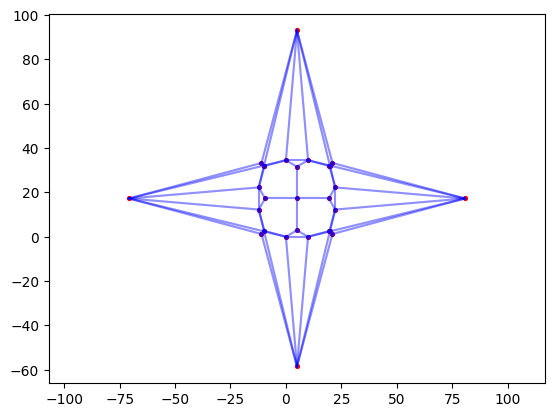

In [ ]:
coords_int = []
for i in range(len(interior_vertices)):
  coords_int.append((interior_vertices[i].x, interior_vertices[i].y))

coords_bound = []
for i in range(len(boundary_vertices)):
  coords_bound.append((boundary_vertices[i].x, boundary_vertices[i].y))

plt.scatter(*zip(*coords_int), s=30, marker=".", color="purple")
plt.scatter(*zip(*coords_bound), s=30, marker=".", color="red")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

for i in range(len(interior_vertices)):
  adj_pts = interior_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(interior_vertices[i], adj_pts[j])

for i in range(len(boundary_vertices)):
  adj_pts = boundary_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(boundary_vertices[i], adj_pts[j])

plt.axis('equal')
plt.show

In [ ]:
i = interior_vertices_name.index("B1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("C1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("E1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("A11")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("A12")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("F1")
p = interior_vertices[i]
print(p.imbal)

# Check imbalance of some representative points before optimizing

(np.float64(3.9968028886505635e-15), np.float64(-3.4416913763379853e-15))
(np.float64(6.106226635438361e-15), np.float64(-5.995204332975845e-15))
(np.float64(-9.325873406851315e-15), np.float64(1.0103029524088925e-14))
(np.float64(0.013658036598403422), np.float64(-0.0007783002481963619))
(np.float64(-0.013658036598407253), np.float64(-0.0007783002481998036))
(np.float64(5.819775926220233e-16), np.float64(0.0))


<function matplotlib.pyplot.show(close=None, block=None)>

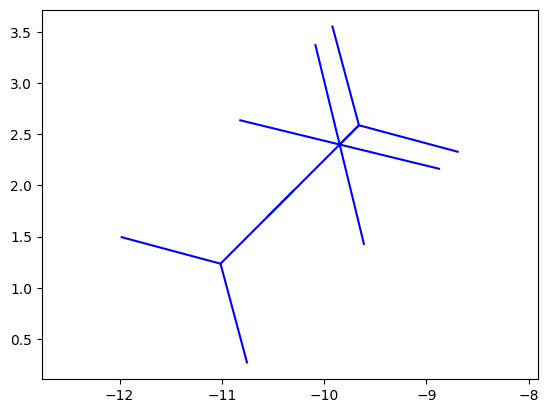

In [ ]:
# Close_up of B1, C1, E1

plt.clf()
plt.close()
i = interior_vertices_name.index("B1")
j = interior_vertices_name.index("C1")
k = interior_vertices_name.index("E1")
coords_int = []
coords_int.append((interior_vertices[i].x, interior_vertices[i].y))
adj_pts = interior_vertices[i].adj
for i2 in range(len(adj_pts)):
  dir = direction(interior_vertices[i], adj_pts[i2])
  magnitude = min(1, distance(interior_vertices[i], adj_pts[i2]))
  draw_line_dir(interior_vertices[i], dir, magnitude)

coords_int.append((interior_vertices[j].x, interior_vertices[j].y))
adj_pts = interior_vertices[j].adj
for j2 in range(len(adj_pts)):
  dir = direction(interior_vertices[j], adj_pts[j2])
  magnitude = min(1, distance(interior_vertices[j], adj_pts[j2]))
  draw_line_dir(interior_vertices[j], dir, magnitude)

coords_int.append((interior_vertices[k].x, interior_vertices[k].y))
adj_pts = interior_vertices[k].adj
for k2 in range(len(adj_pts)):
  dir = direction(interior_vertices[k], adj_pts[k2])
  magnitude = min(1, distance(interior_vertices[k], adj_pts[k2]))
  draw_line_dir(interior_vertices[k], dir, magnitude)


# plt.scatter(*zip(*coords_int), s=100, marker="+", color="purple")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

plt.axis('equal')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

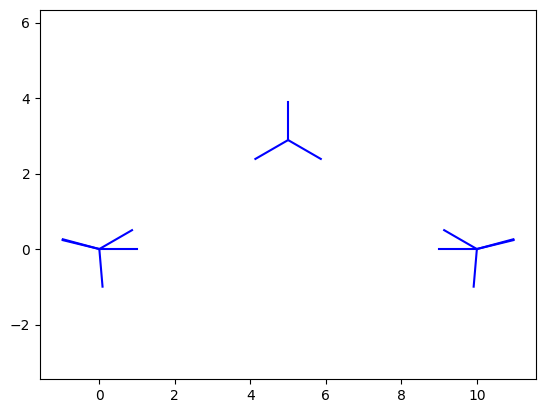

In [ ]:
# Close_up of A11, A12, F1

plt.clf()
plt.close()
i = interior_vertices_name.index("A11")
j = interior_vertices_name.index("A12")
k = interior_vertices_name.index("F1")
coords_int = []
coords_int.append((interior_vertices[i].x, interior_vertices[i].y))
adj_pts = interior_vertices[i].adj
for i2 in range(len(adj_pts)):
  dir = direction(interior_vertices[i], adj_pts[i2])
  magnitude = min(1, distance(interior_vertices[i], adj_pts[i2]))
  draw_line_dir(interior_vertices[i], dir, magnitude)

coords_int.append((interior_vertices[j].x, interior_vertices[j].y))
adj_pts = interior_vertices[j].adj
for j2 in range(len(adj_pts)):
  dir = direction(interior_vertices[j], adj_pts[j2])
  magnitude = min(1, distance(interior_vertices[j], adj_pts[j2]))
  draw_line_dir(interior_vertices[j], dir, magnitude)

coords_int.append((interior_vertices[k].x, interior_vertices[k].y))
adj_pts = interior_vertices[k].adj
for k2 in range(len(adj_pts)):
  dir = direction(interior_vertices[k], adj_pts[k2])
  magnitude = min(1, distance(interior_vertices[k], adj_pts[k2]))
  draw_line_dir(interior_vertices[k], dir, magnitude)


# plt.scatter(*zip(*coords_int), s=100, marker="x", color="purple")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

plt.axis('equal')
plt.show

In [ ]:
# Check length ratio between Segment (A11, A12) and (A11, B1)
a11_i = interior_vertices_name.index("A11")
a11 = interior_vertices[a11_i]
a12_i = interior_vertices_name.index("A12")
a12 = interior_vertices[a12_i]
b1_i = interior_vertices_name.index("B1")
b1 = interior_vertices[b1_i]

dist_a = distance(a11, a12)
print(dist_a)
dist_b = distance(a11, b1)
print(dist_b)

print("Length ratio between Segment (A11, A12) and (A11, B1):", dist_a/dist_b)


10.0
9.999999999999998
Length ratio between Segment (A11, A12) and (A11, B1): 1.0000000000000002


# 4: Optimization Algorithm

## 4.1: Defining Necessary Functions

In [ ]:
def optimize_direction(int_pts: list[Point], bdry_pts: list[Point], alpha: np.float64=0.001, niter: int=1000) -> None:
  '''
  Runs an optimization algorithm the points in int_pts using the direction
  descent method. Each iteration will perturb by a scale of alpha; algorithm
  will runn niter iterations.
  '''

  for i in range(niter):
    for pt in int_pts:
      pt.update_position(pt.x + alpha * pt.imbal[0], pt.y + alpha * pt.imbal[1])


## 4.2: Algorithm Body

In [ ]:
optimize_direction(interior_vertices, boundary_vertices, alpha=0.01, niter = 500000)

<function matplotlib.pyplot.show(close=None, block=None)>

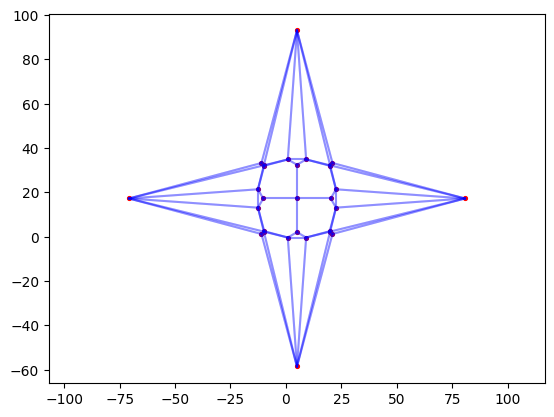

In [ ]:
# Revisualize after iteration

plt.clf()
plt.close()
coords_int = []
for i in range(len(interior_vertices)):
  coords_int.append((interior_vertices[i].x, interior_vertices[i].y))

coords_bound = []
for i in range(len(boundary_vertices)):
  coords_bound.append((boundary_vertices[i].x, boundary_vertices[i].y))

plt.scatter(*zip(*coords_int), s=30, marker=".", color="purple")
plt.scatter(*zip(*coords_bound), s=30, marker=".", color="red")

# Might need BFS/DFS to traverse whole graph and draw all edges
# Alternative is draw all edges twice (current implementation)

for i in range(len(interior_vertices)):
  adj_pts = interior_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(interior_vertices[i], adj_pts[j])

for i in range(len(boundary_vertices)):
  adj_pts = boundary_vertices[i].adj
  for j in range(len(adj_pts)):
    draw_line(boundary_vertices[i], adj_pts[j])

plt.axis('equal')
plt.show

In [ ]:
i = interior_vertices_name.index("B1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("C1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("E1")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("A11")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("A12")
p = interior_vertices[i]
print(p.imbal)

i = interior_vertices_name.index("F1")
p = interior_vertices[i]
print(p.imbal)
# Check imbalance of the representative points

(np.float64(-6.221689829999377e-13), np.float64(-6.539213615042172e-13))
(np.float64(-6.185052470186747e-13), np.float64(-5.56776846849516e-13))
(np.float64(2.19824158875781e-14), np.float64(-2.1316282072803006e-14))
(np.float64(3.1934177524561846e-13), np.float64(-8.90065798841988e-13))
(np.float64(-3.1243063691732686e-13), np.float64(-8.861800182558e-13))
(np.float64(-3.1315292221584094e-14), np.float64(-1.0960121699099545e-12))


<function matplotlib.pyplot.show(close=None, block=None)>

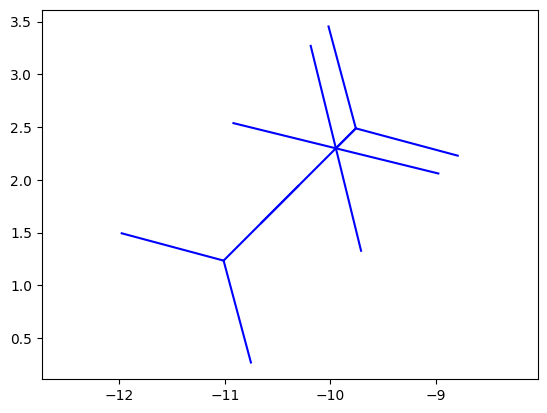

In [ ]:
# Close_up of B1, C1, E1

plt.clf()
plt.close()
i = interior_vertices_name.index("B1")
j = interior_vertices_name.index("C1")
k = interior_vertices_name.index("E1")
coords_int = []
coords_int.append((interior_vertices[i].x, interior_vertices[i].y))
adj_pts = interior_vertices[i].adj
for i2 in range(len(adj_pts)):
  dir = direction(interior_vertices[i], adj_pts[i2])
  magnitude = min(1, distance(interior_vertices[i], adj_pts[i2]))
  draw_line_dir(interior_vertices[i], dir, magnitude)

coords_int.append((interior_vertices[j].x, interior_vertices[j].y))
adj_pts = interior_vertices[j].adj
for j2 in range(len(adj_pts)):
  dir = direction(interior_vertices[j], adj_pts[j2])
  magnitude = min(1, distance(interior_vertices[j], adj_pts[j2]))
  draw_line_dir(interior_vertices[j], dir, magnitude)

coords_int.append((interior_vertices[k].x, interior_vertices[k].y))
adj_pts = interior_vertices[k].adj
for k2 in range(len(adj_pts)):
  dir = direction(interior_vertices[k], adj_pts[k2])
  magnitude = min(1, distance(interior_vertices[k], adj_pts[k2]))
  draw_line_dir(interior_vertices[k], dir, magnitude)


# plt.scatter(*zip(*coords_int), s=100, marker="x", color="purple")

# Alternative is draw all edges twice (current implementation)

plt.axis('equal')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

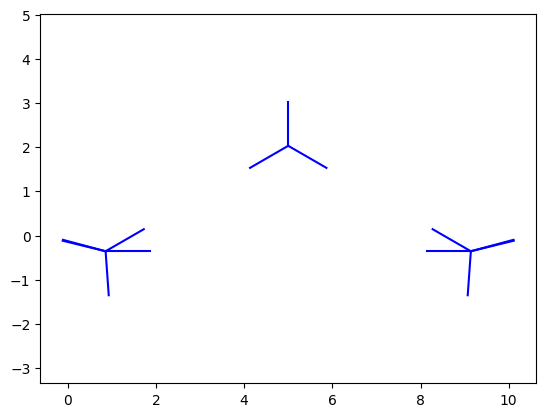

In [ ]:
# Close_up of A11, A12, F1

plt.clf()
plt.close()
i = interior_vertices_name.index("A11")
j = interior_vertices_name.index("A12")
k = interior_vertices_name.index("F1")
coords_int = []
coords_int.append((interior_vertices[i].x, interior_vertices[i].y))
adj_pts = interior_vertices[i].adj
for i2 in range(len(adj_pts)):
  dir = direction(interior_vertices[i], adj_pts[i2])
  magnitude = min(1, distance(interior_vertices[i], adj_pts[i2]))
  draw_line_dir(interior_vertices[i], dir, magnitude)

coords_int.append((interior_vertices[j].x, interior_vertices[j].y))
adj_pts = interior_vertices[j].adj
for j2 in range(len(adj_pts)):
  dir = direction(interior_vertices[j], adj_pts[j2])
  magnitude = min(1, distance(interior_vertices[j], adj_pts[j2]))
  draw_line_dir(interior_vertices[j], dir, magnitude)

coords_int.append((interior_vertices[k].x, interior_vertices[k].y))
adj_pts = interior_vertices[k].adj
for k2 in range(len(adj_pts)):
  dir = direction(interior_vertices[k], adj_pts[k2])
  magnitude = min(1, distance(interior_vertices[k], adj_pts[k2]))
  draw_line_dir(interior_vertices[k], dir, magnitude)


# plt.scatter(*zip(*coords_int), s=100, marker="x", color="purple")

plt.axis('equal')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

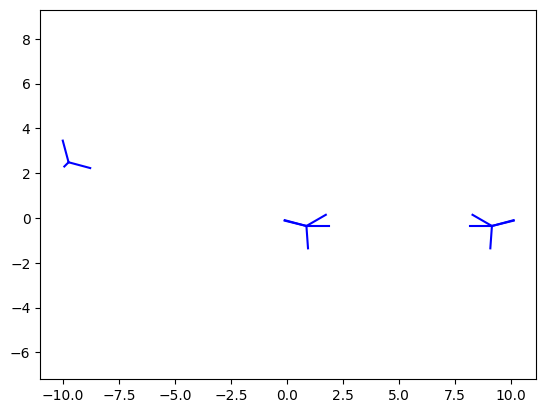

In [ ]:
# Close_up of A11, A12, B1

plt.clf()
plt.close()
i = interior_vertices_name.index("A11")
a11 = interior_vertices[i]
j = interior_vertices_name.index("A12")
k = interior_vertices_name.index("B1")
coords_int = []
coords_int.append((interior_vertices[i].x, interior_vertices[i].y))
adj_pts = interior_vertices[i].adj
for i2 in range(len(adj_pts)):
  dir = direction(interior_vertices[i], adj_pts[i2])
  magnitude = min(1, distance(interior_vertices[i], adj_pts[i2]))
  draw_line_dir(interior_vertices[i], dir, magnitude)

coords_int.append((interior_vertices[j].x, interior_vertices[j].y))
adj_pts = interior_vertices[j].adj
for j2 in range(len(adj_pts)):
  dir = direction(interior_vertices[j], adj_pts[j2])
  magnitude = min(1, distance(interior_vertices[j], adj_pts[j2]))
  draw_line_dir(interior_vertices[j], dir, magnitude)

coords_int.append((interior_vertices[k].x, interior_vertices[k].y))
adj_pts = interior_vertices[k].adj
for k2 in range(len(adj_pts)):
  dir = direction(interior_vertices[k], adj_pts[k2])
  magnitude = min(1, distance(interior_vertices[k], adj_pts[k2]))
  draw_line_dir(interior_vertices[k], dir, magnitude)

# plt.scatter(*zip(*coords_int), s=100, marker="x", color="purple")

plt.axis('equal')
plt.show

In [ ]:
# Output all points centered at P

p_i = interior_vertices_name.index("P")
p = interior_vertices[p_i]

print("Interior Vertices:")
for i in range(len(interior_vertices)):
  print(interior_vertices_name[i], " has coordinate ("
        + str(interior_vertices[i].x - p.x)
        + ", " + str(interior_vertices[i].y - p.y) + "), with imbalance of ("
        + str(interior_vertices[i].imbal[0])
        + ", " + str(interior_vertices[i].imbal[1]) + ")")

print("\nBoundary Vertices:")
for i in range(len(boundary_vertices)):
  print(boundary_vertices_name[i], " has coordinate ("
        + str(boundary_vertices[i].x - p.x)
        + ", " + str(boundary_vertices[i].y - p.y)
        + ")")

Interior Vertices:
A12  has coordinate (4.140657919009092, -17.604122768166796), with imbalance of (-3.1243063691732686e-13, -8.861800182558e-13)
A11  has coordinate (-4.140657919008898, -17.604122768167056), with imbalance of (3.1934177524561846e-13, -8.90065798841988e-13)
B1  has coordinate (-14.75895787103098, -14.758957871025405), with imbalance of (-6.221689829999377e-13, -6.539213615042172e-13)
A42  has coordinate (-17.60412276817126, -4.140657919008653), with imbalance of (-9.273692924693933e-13, 2.945282906452462e-13)
A41  has coordinate (-17.604122768172843, 4.140657919014707), with imbalance of (-9.534595335480844e-13, -3.528566328014904e-13)
B4  has coordinate (-14.758957871034044, 14.758957871023615), with imbalance of (-6.221689829999377e-13, 8.408829188510936e-13)
A32  has coordinate (-4.140657919007883, 17.604122768167475), with imbalance of (2.9032332093947844e-13, 1.063371612985975e-12)
A31  has coordinate (4.140657919010703, 17.60412276816859), with imbalance of (-2.6

# 5: Deriving Properties

Using our optimization algorithm, we can be almost certain that a geodesic net with 4 boundary vertices and 25 balanced vertices exists. Now we need to derive key properties in order to find the analytical solution

In [ ]:
# Check angle around P
print("Interior Vertices angle around P:")
for i in range(len(interior_vertices)):
  arctan_value = radians_to_degrees(np.arctan2(interior_vertices[i].y - p.y, interior_vertices[i].x - p.x))
  print(interior_vertices_name[i], " has angle "
        + str(arctan_value))

Interior Vertices angle around P:
A12  has angle -76.76407097316103
A11  has angle -103.23592902683819
B1  has angle -135.0000000000108
A42  has angle -166.76407097316564
A41  has angle 166.7640709731481
B4  has angle 135.00000000002026
A32  has angle 103.23592902683475
A31  has angle 76.76407097315736
B3  has angle 45.000000000012875
A22  has angle 13.23592902685872
A21  has angle -13.235929026840509
B2  has angle -45.000000000001194
P  has angle 0.0
F1  has angle -89.99999999999858
F2  has angle 9.67367813842534e-12
F3  has angle 89.99999999999889
F4  has angle 179.9999999999998
C1  has angle -135.00000000001066
C2  has angle -45.000000000001144
C3  has angle 45.0000000000129
C4  has angle 135.0000000000199
E1  has angle -135.00000000001006
E2  has angle -45.00000000000082
E3  has angle 45.000000000012946
E4  has angle 135.00000000001927


In [ ]:
# Check angle around A11
a11_i = interior_vertices_name.index("A11")
a11 = interior_vertices[a11_i]

print("Interior Vertices angle around A11:")
for i in range(len(interior_vertices)):
  arctan_value = radians_to_degrees(np.arctan2(interior_vertices[i].y - a11.y, interior_vertices[i].x - a11.x))
  print(interior_vertices_name[i], " has angle "
        + str(arctan_value))

Interior Vertices angle around A11:
A12  has angle 1.7843610048347243e-12
A11  has angle 0.0
B1  has angle 164.99999999997027
A42  has angle 135.0000000000084
A41  has angle 121.76407097316599
B4  has angle 108.16462051030003
A32  has angle 89.99999999999834
A31  has angle 76.76407097315959
B3  has angle 59.715630480902654
A22  has angle 45.00000000001135
A21  has angle 31.76407097316377
B2  has angle 8.561071718656668
P  has angle 76.76407097316182
F1  has angle 30.0000000000359
F2  has angle 42.288957076029675
F3  has angle 82.80889076649886
F4  has angle 122.16957023967771
C1  has angle 166.1927133812596
C2  has angle 7.921307776119762
C3  has angle 59.612462876453
C4  has angle 108.36633401090573
E1  has angle 172.3646432500046
E2  has angle 4.515305710792781
E3  has angle 59.05726724845141
E4  has angle 109.45098015922109


In [ ]:
# Check length ratio between Segment (A11, A12) and (A11, B1)
a11_i = interior_vertices_name.index("A11")
a11 = interior_vertices[a11_i]
a12_i = interior_vertices_name.index("A12")
a12 = interior_vertices[a12_i]
b1_i = interior_vertices_name.index("B1")
b1 = interior_vertices[b1_i]

dist_a = distance(a11, a12)
print(dist_a)
dist_b = distance(a11, b1)
print(dist_b)

print("Length ratio between Segment (A11, A12) and (A11, B1):", dist_a/dist_b)

8.28131583801799
10.992873016779516
Length ratio between Segment (A11, A12) and (A11, B1): 0.7533349858019277


In [ ]:
# Check angle around C1
c1_i = interior_vertices_name.index("C1")
c1 = interior_vertices[c1_i]

print("Interior Vertices angle around C1:")
for i in range(len(interior_vertices)):
  arctan_value = radians_to_degrees(np.arctan2(interior_vertices[i].y - c1.y, interior_vertices[i].x - c1.x))
  print(interior_vertices_name[i], " has angle "
        + str(arctan_value))

print("\nBoundary Vertices angle around C1:")
for i in range(len(boundary_vertices)):
  arctan_value = radians_to_degrees(np.arctan2(boundary_vertices[i].y - c1.y, boundary_vertices[i].x - c1.x))
  print(boundary_vertices_name[i], " has angle "
        + str(arctan_value))

Interior Vertices angle around C1:
A12  has angle -7.921307776120852
A11  has angle -13.807286618740381
B1  has angle 45.000000000001414
A42  has angle 103.80728661874011
A41  has angle 97.92130777612226
B4  has angle 89.63520334430173
A32  has angle 71.63366598910069
A31  has angle 59.612462876439444
B3  has angle 45.00000000000103
A22  has angle 30.38753712355771
A21  has angle 18.36633401088685
B2  has angle 0.3647966557034261
P  has angle 44.999999999989335
F1  has angle -1.017205958751461
F2  has angle 26.363024283692756
F3  has angle 63.636975716302146
F4  has angle 91.01720595874353
C1  has angle 0.0
C2  has angle -2.5456178460313827e-12
C3  has angle 45.00000000000112
C4  has angle 90.00000000000958
E1  has angle -135.00000000000148
E2  has angle -1.969196589706095
E3  has angle 45.00000000000155
E4  has angle 91.96919658970224

Boundary Vertices angle around C1:
D1  has angle -76.19271338128733
D2  has angle 9.356600140579863
D3  has angle 80.6433998594194
D4  has angle 166.19

In [ ]:
c1_i = interior_vertices_name.index("C1")
c1 = interior_vertices[c1_i]
e1_i = interior_vertices_name.index("E1")
e1 = interior_vertices[e1_i]
b1_i = interior_vertices_name.index("B1")
b1 = interior_vertices[b1_i]
p_i = interior_vertices_name.index("P")
p = interior_vertices[p_i]

dist_a = distance(c1, b1)
print(dist_a)
dist_b = distance(e1, c1)
print(dist_b)
dist_c = distance(b1, p)
print(dist_c)

print("Length ratio between Segment (C1, B1) and (C1, E1):", dist_a/dist_b)
print("Length ratio between Segment (C1, B1) and (B1, P):", dist_a/dist_c)

# Notice that the interior dodecagon preserves the angle property and has equal
# side length. This proves that a perturbation of parameter t is needed for
# the final net.

0.2674907443896917
1.505439893796792
20.87231838770121
Length ratio between Segment (C1, B1) and (C1, E1): 0.17768277929387613
Length ratio between Segment (C1, B1) and (B1, P): 0.012815574169628793


In [ ]:
# Check angle around D1
d1_i = boundary_vertices_name.index("D1")
d1 = boundary_vertices[d1_i]

print("Interior Vertices angle around D1:")
for i in range(len(interior_vertices)):
  arctan_value = radians_to_degrees(np.arctan2(interior_vertices[i].y - d1.y, interior_vertices[i].x - d1.x))
  print(interior_vertices_name[i], " has angle "
        + str(arctan_value))

print("\nBoundary Vertices angle around D1:")
for i in range(len(boundary_vertices)):
  arctan_value = radians_to_degrees(np.arctan2(boundary_vertices[i].y - d1.y, boundary_vertices[i].x - d1.x))
  print(boundary_vertices_name[i], " has angle "
        + str(arctan_value))

Interior Vertices angle around D1:
A12  has angle 85.92832369832814
A11  has angle 94.07167630167282
B1  has angle 103.59843275454753
A42  has angle 103.80728661871682
A41  has angle 102.42330565156492
B4  has angle 99.25923349794846
A32  has angle 92.53903973991575
A31  has angle 87.46096026008327
B3  has angle 80.74076650205993
A22  has angle 77.57669434844159
A21  has angle 76.1927133812887
B2  has angle 76.40156724545857
P  has angle 90.00000000000044
F1  has angle 90.00000000000018
F2  has angle 78.64716446493487
F3  has angle 90.00000000000018
F4  has angle 101.352835535072
C1  has angle 103.80728661871267
C2  has angle 76.19271338129235
C3  has angle 80.64339985942313
C4  has angle 99.35660014058465
E1  has angle 105.0000000000003
E2  has angle 74.99999999999929
E3  has angle 80.10390936101608
E4  has angle 99.89609063898662

Boundary Vertices angle around D1:
D1  has angle 0.0
D2  has angle 44.99999999999969
D3  has angle 89.9999999999999
D4  has angle 135.00000000000017


# 6: Solving for Exact Values

In [ ]:
# Finding expression for 2 unknown angles at A11
a, b = symbols('a b')
eq1 = Eq(cos(a) + cos(b) + 1 + cos(-pi / 6) + cos(pi * 13/12), 0)
eq2 = Eq(sin(a) + sin(b) + sin(-pi / 6) + sin(pi * 13/12), 0)
sol_angle = solve((eq1, eq2), (a, b))
print(sol_angle)

[(pi - asin(sin(2*atan(-sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + sqrt(2)/2 + sqrt(6)/2 + sqrt(3))) - sqrt(2)/4 + 1/2 + sqrt(6)/4), -2*atan(-sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + sqrt(2)/2 + sqrt(6)/2 + sqrt(3))), (asin(-sqrt(2)/4 + sin(2*atan(sqrt(2)/2 + sqrt(6)/2 + sqrt(3) + sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)))) + 1/2 + sqrt(6)/4), -2*atan(sqrt(2)/2 + sqrt(6)/2 + sqrt(3) + sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6))))]


In [ ]:
print("Exact Values:")
print("a =", sol_angle[0][0])
print("b =", sol_angle[1][0])

print("\nNumerical Values (Radians):")
print("a =", sol_angle[0][0].evalf())
print("b =", sol_angle[1][0].evalf())

print("\nNumerical Values (Degrees):")
print("a =", (sol_angle[0][0] / pi * 180).evalf())
print("b =", (sol_angle[1][0] / pi * 180).evalf())

Exact Values:
a = pi - asin(sin(2*atan(-sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + sqrt(2)/2 + sqrt(6)/2 + sqrt(3))) - sqrt(2)/4 + 1/2 + sqrt(6)/4)
b = asin(-sqrt(2)/4 + sin(2*atan(sqrt(2)/2 + sqrt(6)/2 + sqrt(3) + sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)))) + 1/2 + sqrt(6)/4)

Numerical Values (Radians):
a = 3.38257526585547
b = 1.49973216925628

Numerical Values (Degrees):
a = 193.807286618861
b = 85.9283236983847


In [ ]:
# Given angles a and b, we can derive an expression for the ratio between the
# length of segment (A11, A12) and (A11, B1).

alpha = sol_angle[0][0]
beta = sol_angle[1][0]

x = symbols('x')
eq3 = Eq((1 - cot(3 * pi / 2 - alpha)) / (1 - cot(beta)),
        (sqrt(6) * (1 - cot(3 * pi / 2 - alpha)) + x) / (sqrt(6) + x))
sol_line = solve(eq3, x)
print(sol_line)


[3*sqrt(-10*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 7*sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*sqrt(3) + 6*sqrt(2) + 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 20 + 5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)))*(-37002394*sqrt(-5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*sqrt(3) + 6*sqrt(2) + 7*sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 10*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 20) - 26164643*sqrt(2)*sqrt(-5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*sqrt(3) + 6*sqrt(2) + 7*sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 10*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 20) - 21357574*sqrt(3)*sqrt(-5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*sqrt(3) + 6*s

In [ ]:
print("Exact Value:", sol_line)
print("\nNumerical Value:", sol_line[0].evalf())

a11_i = interior_vertices_name.index("A11")
a11 = interior_vertices[a11_i]
a12_i = interior_vertices_name.index("A12")
a12 = interior_vertices[a12_i]
b1_i = interior_vertices_name.index("B1")
b1 = interior_vertices[b1_i]

dist_a = distance(a11, a12)
dist_b = distance(a11, b1)

print("Numerical Value (Iterated):", dist_a/dist_b)

Exact Value: [3*sqrt(-10*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 7*sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*sqrt(3) + 6*sqrt(2) + 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 20 + 5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)))*(-37002394*sqrt(-5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*sqrt(3) + 6*sqrt(2) + 7*sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 10*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 20) - 26164643*sqrt(2)*sqrt(-5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*sqrt(3) + 6*sqrt(2) + 7*sqrt(2)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 10*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) + 20) - 21357574*sqrt(3)*sqrt(-5*sqrt(6)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(3)*sqrt(-5*sqrt(3) - 6 + 6*sqrt(2) + 4*sqrt(6)) - 6*sqrt(6) - 4*

In [ ]:
x = symbols('x')
a, b = symbols('a b')
eq3 = Eq((1 - cot(3 * pi / 2 - a)) / (1 - cot(b)),
        (sqrt(6) * (1 - cot(3 * pi / 2 - a)) + x) / (sqrt(6) + x))
sol_line_expr = solve(eq3, x)
print(sol_line_expr)

[sqrt(6)*(1 - tan(a))/(tan(a)*tan(b) - 1)]


This means that we have now obtained the exact values for the necessary angles and edge ratios, with:
- $\alpha = \pi - \arcsin(\sin(2\cdot \arctan(-\sqrt{2}\cdot\sqrt(-5\cdot\sqrt{3} - 6 + 6\cdot \sqrt{2} + 4\cdot \sqrt{6}) - \sqrt{-5\cdot \sqrt{3} - 6 + 6\cdot\sqrt{2} + 4\cdot\sqrt{6}} + \sqrt{2}/2 + \sqrt{6}/2 + \sqrt{3})) - \sqrt{2}/4 + 1/2 + \sqrt{6}/4)$